<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [4]:
pip install gdown -q


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

In [ ]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [341]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV


from sklift.models import (SoloModel,
                           TwoModels,
                           ClassTransformation,
                           ClassTransformationReg)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score,
                            make_uplift_scorer)
from sklift.viz import plot_qini_curve

from causalml.inference.meta import BaseTClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import qini_score

from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

In [194]:
people_in_campaings = pd.read_csv('../study and smth/ДЗ по Uplift обновленное/PEOPLE_IN_CAMPAINGS_FINAL.csv')
contracts = pd.read_csv('../study and smth/ДЗ по Uplift обновленное/CONTRACTS_FINAL.csv')
campaings = pd.read_csv('../study and smth/ДЗ по Uplift обновленное/CAMPAINGS.csv')
features = pd.read_csv('../study and smth/ДЗ по Uplift обновленное/AGGS_FINAL.csv')

##### Для начала посмотрим совпадает ли количество клиентов в тесте/контроле по кампаниям

In [195]:
campaings

,Unnamed: 0,campaing_id,product_id,channel
0,0,iddqd,1,push
1,1,idclip,1,sms
2,2,iddt,1,banner
3,3,idkfa,1,other_ads


In [196]:
people_in_campaings.groupby(['campaing_id','t_flag'],as_index=False).agg({'user_id':'nunique'})

,campaing_id,t_flag,user_id
0,idclip,0,60000
1,idclip,1,60000
2,iddqd,0,80000
3,iddqd,1,80000
4,iddt,0,60000
5,iddt,1,60000
6,idkfa,0,60000
7,idkfa,1,60000


##### Посмотрим пропуски и дубли

In [197]:
people_in_campaings.isna().sum().sum()

0

In [198]:
(len(people_in_campaings.drop_duplicates()) == len(people_in_campaings.drop_duplicates()))

True

In [199]:
contracts.isna().sum().sum()

0

In [200]:
(len(contracts.drop_duplicates()) == len(contracts.drop_duplicates()))

True

In [201]:
features.isna().sum().sum()

0

In [202]:
features

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
0,104548,0.654343,-1.439286,-0.011475,2.039457,0.843580,-0.977480,-0.768019,-1.044127,0.025673,2025-01-31,1066338,26,Ufa
1,38396,2.583579,1.755569,3.360186,-1.122864,0.034201,-0.269607,-1.503646,1.040289,-1.691606,2024-11-30,13900,35,Ufa
2,227077,0.296030,-0.937075,1.073280,1.874636,-0.981216,-1.100187,-0.331181,-1.575637,0.474965,2025-03-31,4063636,28,Ufa
3,304649,2.329328,-1.345159,0.345066,0.755373,-0.082842,0.028439,0.919211,0.808793,-0.560004,2025-03-31,1025488,27,Moscow
4,239518,0.167643,1.587099,0.165357,0.289758,-1.108840,-1.501819,0.615588,1.631203,-0.208419,2025-02-28,4040555,37,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759995,100191,0.311284,-0.232406,-0.208223,1.006051,-1.498279,0.306518,1.135627,1.169791,-0.106392,2025-02-28,61957,38,Ufa
2759996,342943,-1.970020,1.180142,-0.572525,1.052022,-0.654687,0.744590,-2.342623,-0.136155,0.582400,2025-01-31,132172,40,Moscow
2759997,186830,0.403995,-0.350153,-0.584462,0.123843,-1.015746,0.922963,1.549083,1.210031,-0.706992,2025-03-31,4028256,34,Smolensk
2759998,76230,2.218275,-0.344427,1.281239,3.781907,3.658907,1.282129,0.324350,0.982721,2.046261,2025-02-28,1097844,40,Smolensk


In [203]:
(len(features.drop_duplicates(subset=['user_id','report_dt'])) == len(features.drop_duplicates()))

True

##### Пропусков и очевидных дублей нет.

In [204]:
contracts.groupby(['user_id'],as_index=False).agg({'contract_id':'count'}).sort_values('contract_id')

,user_id,contract_id
0,5,1
190868,2089280,1
190869,2089281,1
190870,2089282,1
190871,2089283,1
...,...,...
95436,1035336,1
95435,1035334,1
95434,1035332,1
95440,1035383,1


In [205]:
# проверяем даже не nunique для t_flag, а просто количество. Один флаг за кампанию на юзера
people_in_campaings.groupby(['user_id','campaing_id'],as_index=False).agg({'t_flag':'count'}).sort_values('t_flag')




,user_id,campaing_id,t_flag
0,1,idclip,1
346674,2066674,idkfa,1
346673,2066673,idkfa,1
346672,2066672,idkfa,1
346671,2066671,idkfa,1
...,...,...,...
173326,126106,iddqd,1
173325,126106,idclip,1
173324,126105,iddqd,1
173337,126114,iddqd,1


##### Пока все нормально, можем  собрать таргет

In [206]:
contracts

,Unnamed: 0,user_id,contract_date,product_id,contract_id
0,39735,4008279,2024-11-03,1,0001_2024-11-03_4008279
1,44062,2079035,2024-11-08,1,0001_2024-11-08_2079035
2,9286,103088,2024-11-13,1,0001_2024-11-13_103088
3,45573,2026788,2024-11-02,1,0001_2024-11-02_2026788
4,150378,52269,2024-11-17,1,0001_2024-11-17_52269
...,...,...,...,...,...
286311,34316,1117397,2024-11-28,1,0001_2024-11-28_1117397
286312,101067,2071348,2024-11-12,1,0001_2024-11-12_2071348
286313,5389,4061197,2024-11-07,1,0001_2024-11-07_4061197
286314,33660,1139038,2024-11-02,1,0001_2024-11-02_1139038


In [207]:
people_contracts = (campaings[['campaing_id','channel']].merge(people_in_campaings,'left','campaing_id')
        .merge(contracts[['user_id','contract_date']],'left','user_id')
)

# определяем границу для контрольной группы
people_contracts['deadline'] = people_contracts.contract_date.apply(lambda x: str(x)[:-2]+'21').replace('n21',None)
people_contracts.delivery_date = people_contracts.delivery_date.replace('unknown',None)
# для тестовой
people_contracts.loc[people_contracts.t_flag==1,'deadline'] = pd.to_datetime(people_contracts.loc[people_contracts.t_flag==1,'delivery_date']) + timedelta(days=14)

people_contracts.contract_date = pd.to_datetime(people_contracts.contract_date)
people_contracts.deadline = pd.to_datetime(people_contracts.deadline) 


people_contracts['target'] = (people_contracts.contract_date < people_contracts.deadline).astype(int)
people_contracts = people_contracts.drop(['campaing_id','Unnamed: 0'],axis=1)
people_contracts.loc[people_contracts.t_flag==1,'broken'] = people_contracts.contract_date.astype(str)<people_contracts.delivery_date
people_contracts.loc[people_contracts.t_flag==0,'broken'] = people_contracts.contract_date.astype(str)<'2024-11-01'
people_contracts


,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,broken
0,push,1162,1,2024-11-08,2024-11-13,2024-11-22,1,False
1,push,42991,1,2024-11-07,NaT,2024-11-21,0,False
2,push,24623,0,None,NaT,NaT,0,False
3,push,116064,0,None,2024-11-08,2024-11-21,1,False
4,push,139714,0,None,NaT,NaT,0,False
...,...,...,...,...,...,...,...,...
519995,other_ads,2113479,0,None,NaT,NaT,0,False
519996,other_ads,2116899,1,2024-11-08,2024-11-14,2024-11-22,1,False
519997,other_ads,2052080,1,2024-11-07,2024-11-25,2024-11-21,0,False
519998,other_ads,2046148,1,2024-11-06,2024-11-12,2024-11-20,1,False


In [208]:
people_contracts[people_contracts.t_flag==1].loc[people_contracts.broken==True]

,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,broken
19,push,58929,1,2024-11-08,2024-11-03,2024-11-22,1,True
70,push,147970,1,2024-11-05,2024-11-02,2024-11-19,1,True
106,push,31410,1,2024-11-08,2024-11-01,2024-11-22,1,True
129,push,20156,1,2024-11-06,2024-11-02,2024-11-20,1,True
137,push,128462,1,2024-11-07,2024-11-02,2024-11-21,1,True
...,...,...,...,...,...,...,...,...
519897,other_ads,2003383,1,2024-11-05,2024-11-01,2024-11-19,1,True
519911,other_ads,2001715,1,2024-11-05,2024-11-01,2024-11-19,1,True
519951,other_ads,2072264,1,2024-11-06,2024-11-01,2024-11-20,1,True
519955,other_ads,2017454,1,2024-11-06,2024-11-03,2024-11-20,1,True


In [210]:
# выведем долю контрактов составленных с датой меньше даты доставки

broken_campaigns = (
    people_contracts
    .groupby(['channel','t_flag'], as_index=False)
    .agg(
        total_clients=('user_id', 'count'),
        broken_count=('broken', 'sum'),
        broken_ratio=('broken', 'mean')
    )
    .query('broken_count > 0')
    .sort_values('broken_ratio', ascending=False)
)

broken_campaigns

,channel,t_flag,total_clients,broken_count,broken_ratio
7,sms,1,60000,11847,0.19745
3,other_ads,1,60000,5973,0.09955
5,push,1,80000,6823,0.085288
1,banner,1,60000,5102,0.085033


In [211]:
# посмотрим какая доля контрактов после доставки если 
result = people_contracts.groupby(["channel", "delivery_date"]).agg(
    target_mean_t1=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 1].index)].mean()),
    target_count_t1=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 1].index)].count())
).reset_index()
result

,channel,delivery_date,target_mean_t1,target_count_t1
0,banner,2024-11-04,0.690292,12021
1,banner,2024-11-05,0.681880,11788
2,banner,2024-11-06,0.689419,12116
3,banner,2024-11-07,0.692537,12086
4,banner,2024-11-08,0.684461,11989
5,other_ads,2024-11-04,0.663884,13177
6,other_ads,2024-11-05,0.663901,13136
7,other_ads,2024-11-06,0.662600,13115
8,other_ads,2024-11-07,0.656243,13367
9,other_ads,2024-11-08,1.000000,7205


In [270]:
# по кампаниям other_ads и sms какая-то проблема 2024-11-08, эти значения не учитываем при подсчете эффективности

result = people_contracts.loc[people_contracts.broken==False].loc[(~people_contracts.channel.isin(['other_ads','sms'])) | (people_contracts.delivery_date!='2024-11-08')].groupby(["channel", ]).agg(
    target_mean_t1=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 1].index)].mean()),
    target_mean_t0=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 0].index)].mean()),
    target_count_t1=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 1].index)].count()),
    target_count_t0=("target", lambda x: x[x.index.isin(people_contracts[people_contracts["t_flag"] == 0].index)].count())
).reset_index()
result['uplift_effieciency'] = result.target_mean_t1 - result.target_mean_t0
result

,channel,target_mean_t1,target_mean_t0,target_count_t1,target_count_t0,uplift_effieciency
0,banner,0.658731,0.400733,54898,60000,0.257997
1,other_ads,0.618470,0.400733,46822,60000,0.217737
2,push,0.657843,0.202150,73177,80000,0.455693
3,sms,0.210403,0.684917,45698,60000,-0.474514


In [268]:
# посмотрим не перекликаются ли пользователи из одной группы в другую
agg = people_contracts.groupby('user_id',as_index=False).agg({'channel':'nunique','t_flag':'nunique'})
people_contracts.loc[people_contracts.user_id.isin(agg.loc[agg.channel>=2].user_id)]

,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,broken
0,push,1162,1,2024-11-08,2024-11-13,2024-11-22,1,False
1,push,42991,1,2024-11-07,NaT,2024-11-21,0,False
7,push,709,1,2024-11-07,2024-11-15,2024-11-21,1,False
14,push,141699,1,2024-11-06,NaT,2024-11-20,0,False
15,push,132908,1,2024-11-04,2024-11-12,2024-11-18,1,False
...,...,...,...,...,...,...,...,...
279990,sms,4179,0,None,2024-11-16,2024-11-21,1,False
279991,sms,151190,0,None,2024-11-12,2024-11-21,1,False
279994,sms,83727,0,None,2024-11-13,2024-11-21,1,False
279996,sms,92223,0,None,2024-11-14,2024-11-21,1,False


In [271]:

people_contracts.loc[people_contracts.user_id.isin([4179])]

,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,broken
139191,push,4179,1,2024-11-05,2024-11-16,2024-11-19,1,False
279990,sms,4179,0,None,2024-11-16,2024-11-21,1,False


### Либо в push вместо теста нам попалась выборка из смс либо наоборот. Посмотрим по датам контрактов как они распределены

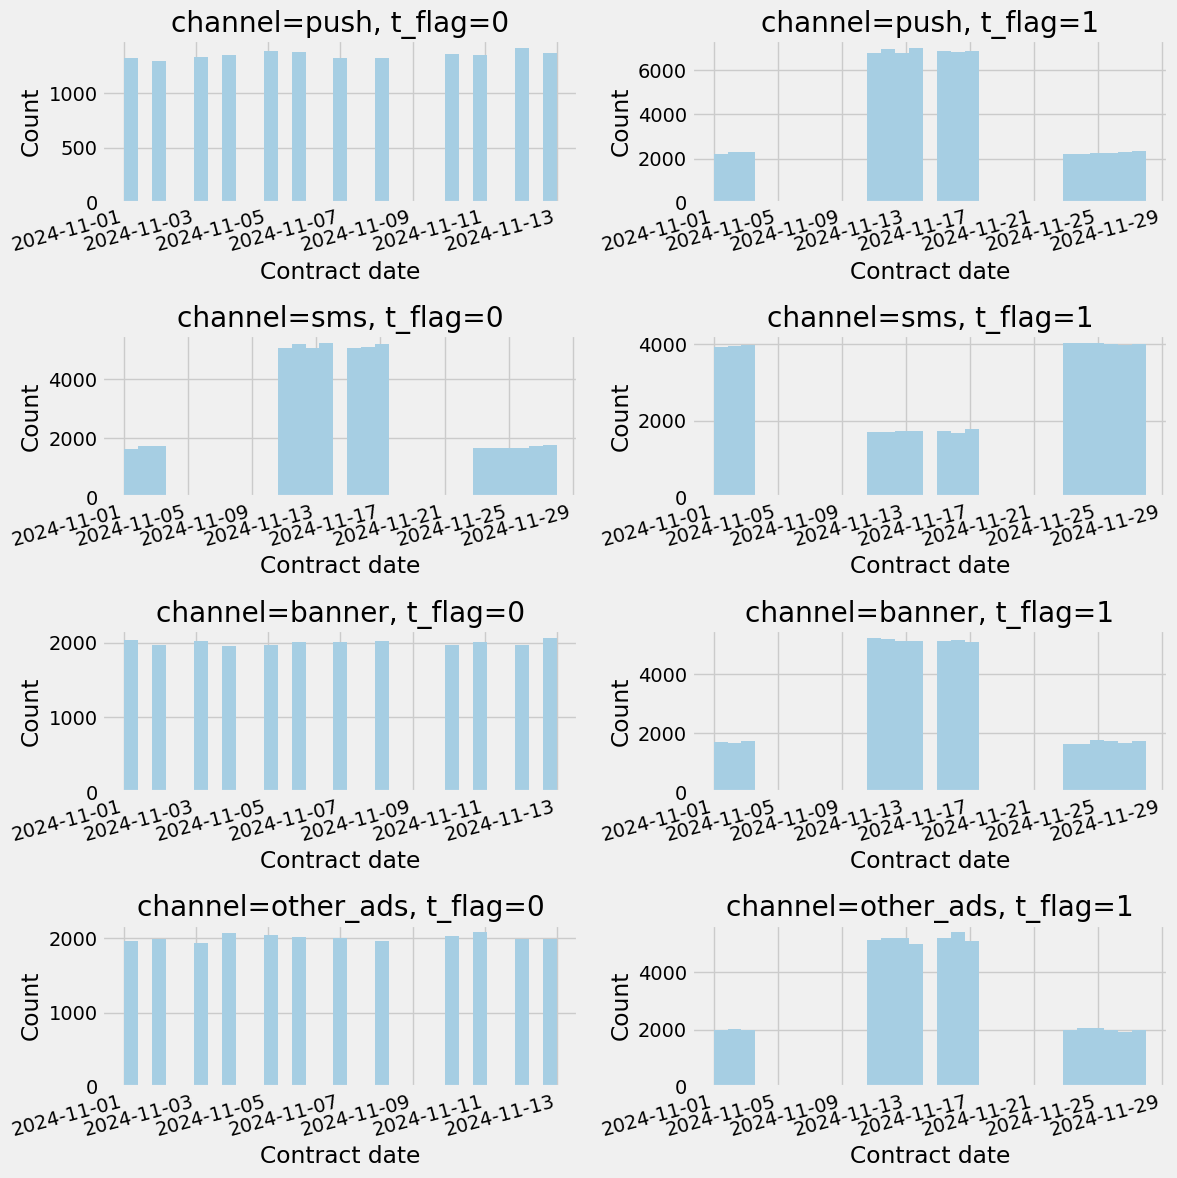

In [262]:


unique_channels = people_contracts.channel.unique()
n_channels = len(unique_channels)

# Создаём фигуру и сетку субплотов
# nrows = количество каналов, ncols = 2 (так как flag = [0, 1])
fig, axes = plt.subplots(nrows=n_channels, ncols=2, 
                         figsize=(12, 3*n_channels),  # Ширина и высота подбираем
                         sharex=False, sharey=False)

for i, channel in enumerate(unique_channels):
    for j, flag in enumerate([0, 1]):
        # Выбираем соответствующий DataFrame
        subset = people_contracts.loc[
            (people_contracts.t_flag == flag) & (people_contracts.channel == channel)
        ]
        
        # Текущая ось на сетке
        ax = axes[i, j] if n_channels > 1 else axes[j]
        
        # Строим гистограмму на текущей оси
        ax.hist(subset['contract_date'], bins=31)
        plt.setp(ax.get_xticklabels(), rotation=15, ha='right')
        
        # Настраиваем заголовки и подписи
        ax.set_title(f"channel={channel}, t_flag={flag}")
        ax.set_xlabel("Contract date")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

### ваши выводы здесь

##### В канале SMS  почти 20% контрактов заключено до доставки коммуникации, в то время как во всех остальных случаях это значение не превышает 1%.  Учитывая, что в остальных каналах есть некоторое подобие нормального распределения в виде дискретных значений, организованных в бины, а в смс канале оно как будто отзеркалено, то можно предположить что это ошибка в данных и определять по таким датам таргет это или нет уже будет ошибкой. К тому же данные в контрольных группах распределены равномерно, а в смс канале они распределены так как в должы были бы быть распределены в тесте (видимо в push кампании тест все-таки корректно заполнен). 
### Вывод: у нас отсутсвует контрольная группа в смс канале,  удаляем эту кампанию


### Вывод 2: Судя по результатам в столбце uplift_effieciency, самой эффективной кампанией оказалась push, её эффективность по uplift составила 0.484875

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

In [273]:
clear_set = people_contracts\
    .loc[(~people_contracts.channel.isin(['other_ads'])) | (people_contracts.delivery_date!='2024-11-08')]\
    .loc[~people_contracts.channel.isin(['sms'])]\
    .loc[people_contracts.broken==False].drop('broken',axis=1)\
    .merge(features.loc[features.report_dt=='2024-09-30'],'left','user_id')
clear_set

,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city
0,push,1162,1,2024-11-08,2024-11-13,2024-11-22,1,1161,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,2024-09-30,39,Moscow
1,push,42991,1,2024-11-07,NaT,2024-11-21,0,42990,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,2024-09-30,43,Moscow
2,push,24623,0,None,NaT,NaT,0,24622,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
3,push,116064,0,None,2024-11-08,2024-11-21,1,116063,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,2024-09-30,33,Ufa
4,push,139714,0,None,NaT,NaT,0,139713,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,2024-09-30,27,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374892,other_ads,2103141,1,2024-11-06,2024-11-12,2024-11-20,1,103141,0.189217,1.496285,-0.533316,-0.031895,2.101699,0.449041,1.473282,1.239368,-0.531401,2024-09-30,28,Ufa
374893,other_ads,2113479,0,None,NaT,NaT,0,113479,0.192611,-2.539540,-0.278562,-0.491431,0.000000,-0.161891,1.028837,1.110961,-0.403948,2024-09-30,21,Smolensk
374894,other_ads,2052080,1,2024-11-07,2024-11-25,2024-11-21,0,52080,-3.110953,-2.103578,1.327757,2.637593,0.374258,-0.133801,1.238193,0.767082,-1.068198,2024-09-30,36,Ufa
374895,other_ads,2046148,1,2024-11-06,2024-11-12,2024-11-20,1,46148,1.284552,-0.501500,-1.335027,0.754281,-1.614827,-0.975406,1.936397,1.443528,-0.476519,2024-09-30,43,Ufa


**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

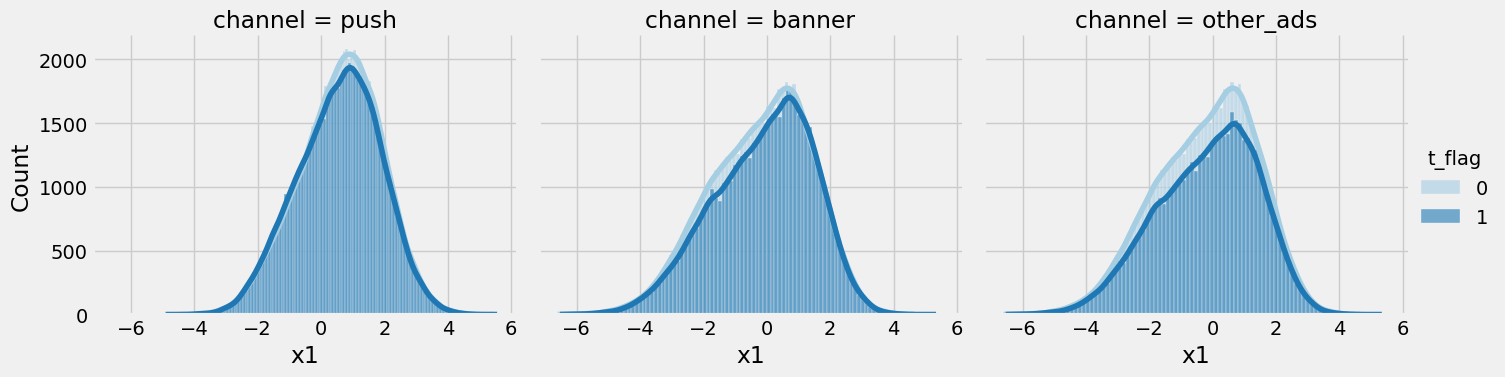

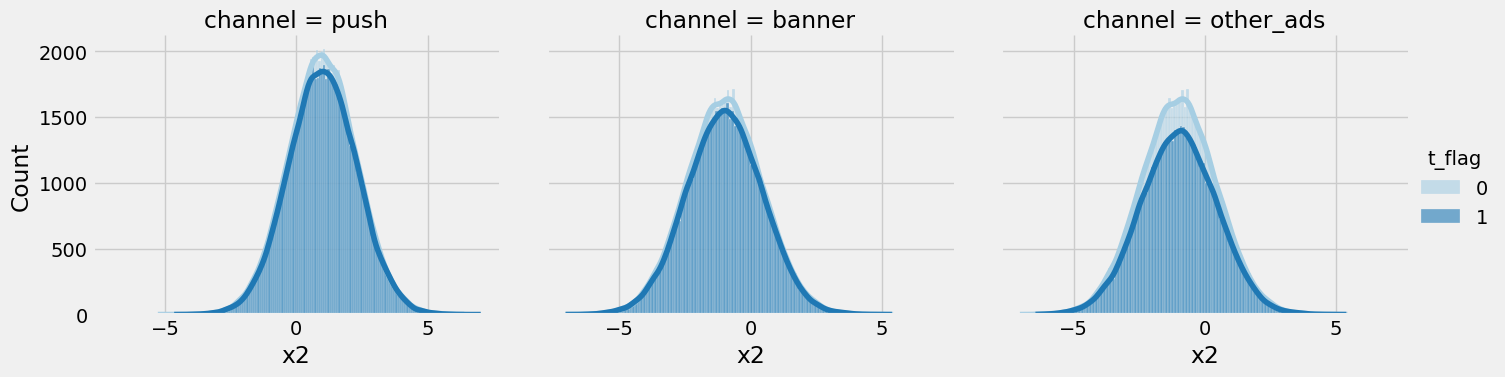

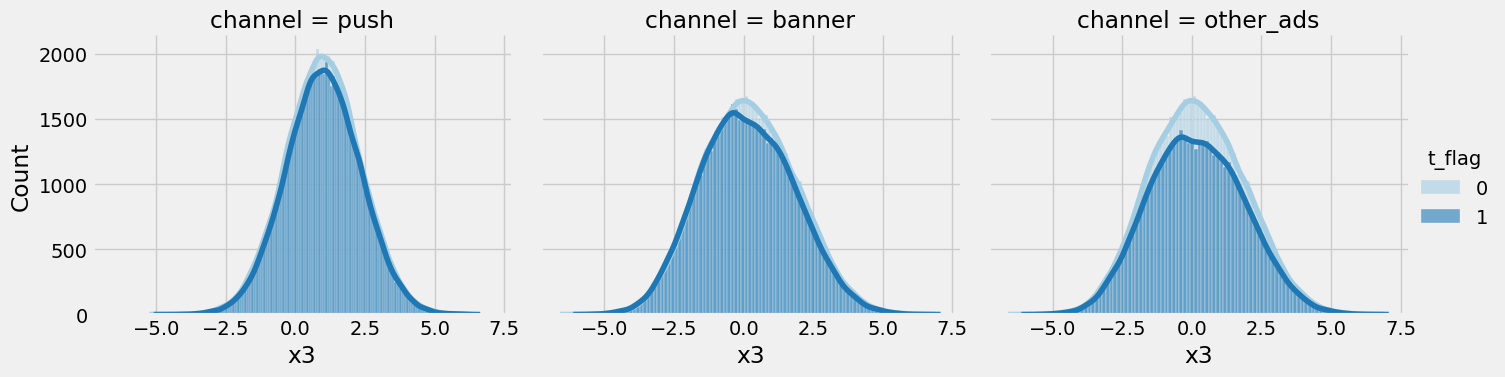

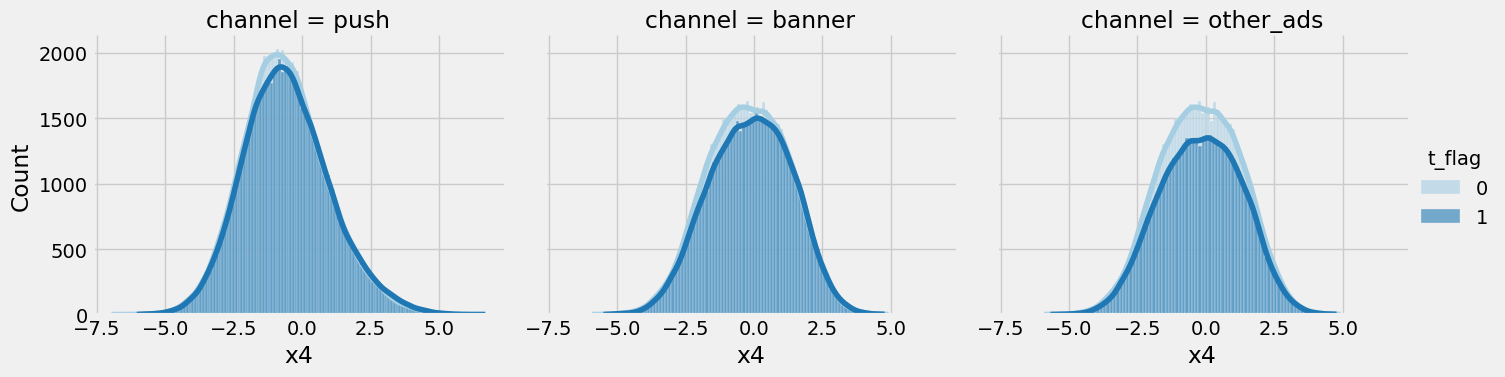

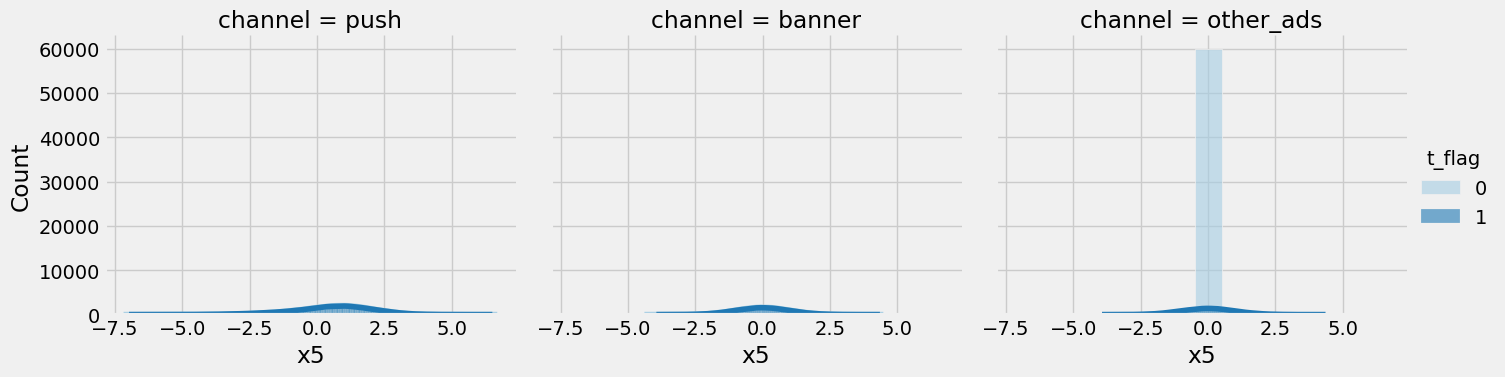

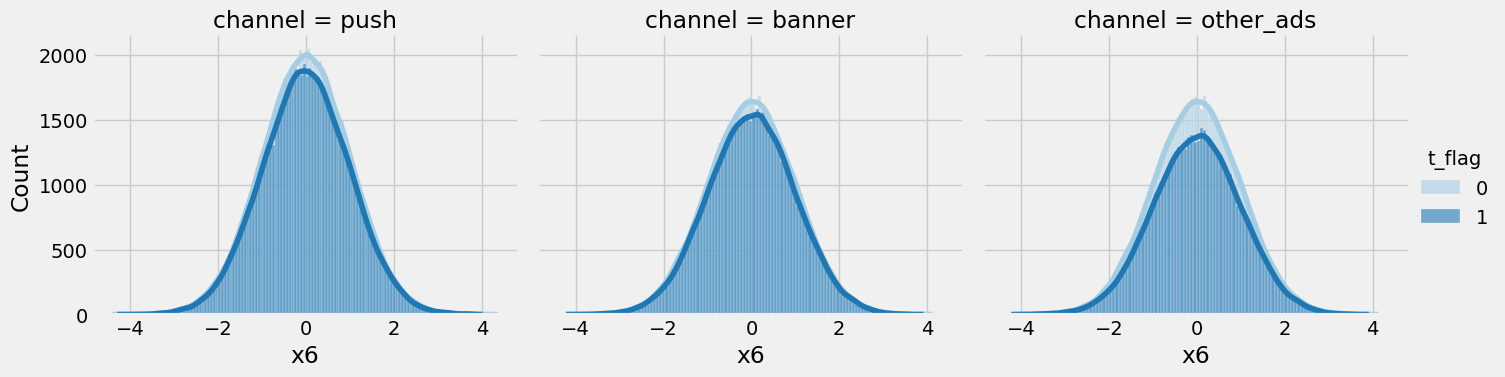

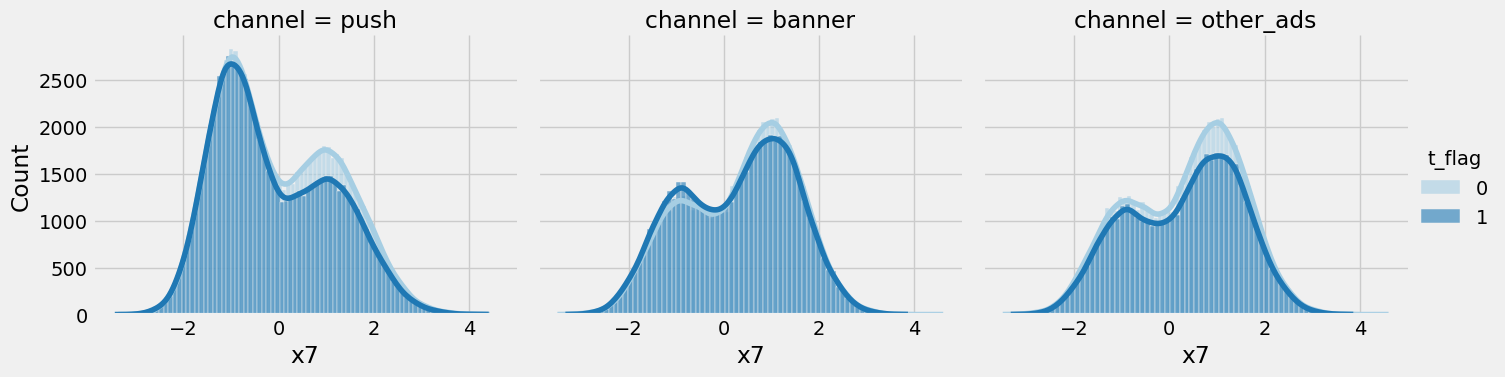

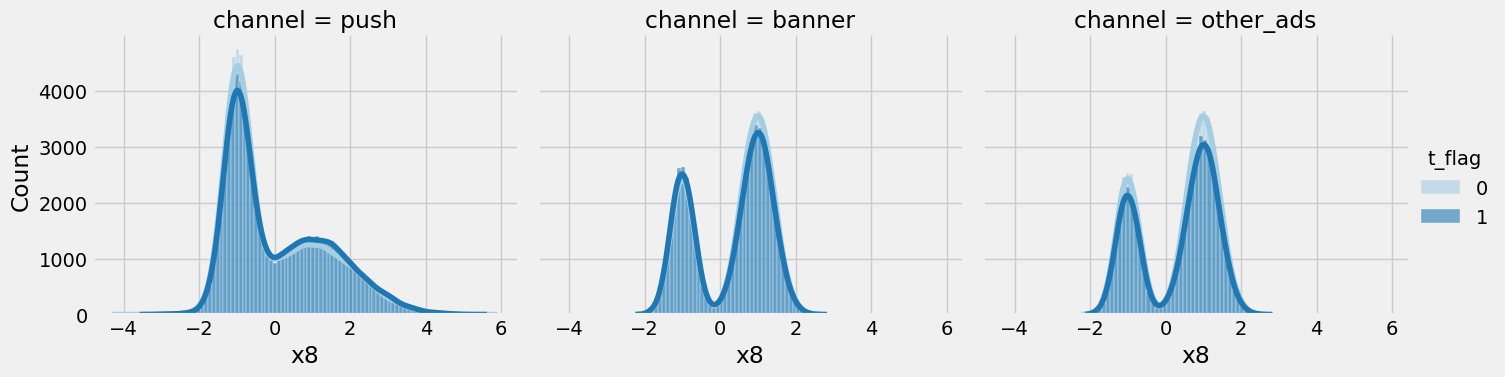

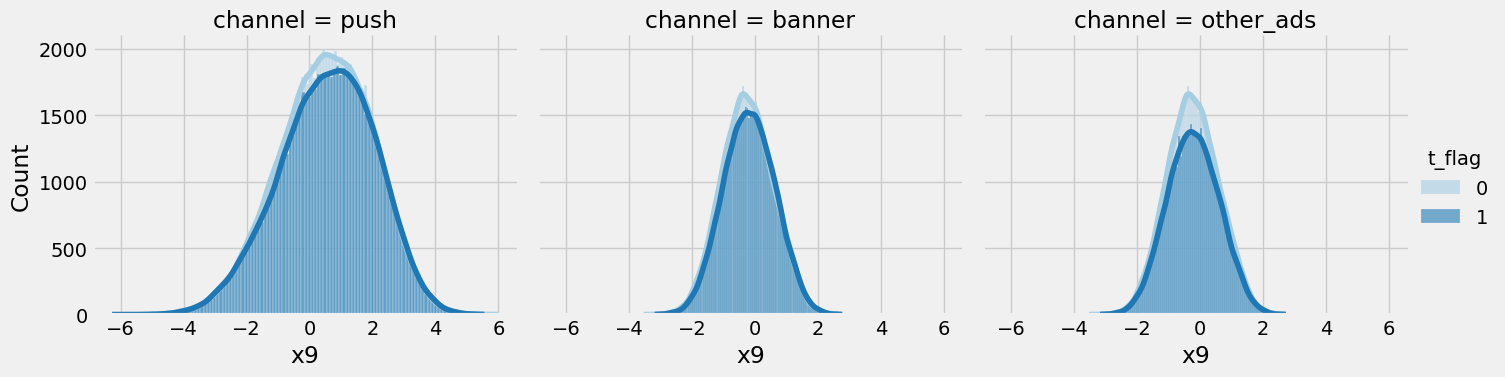

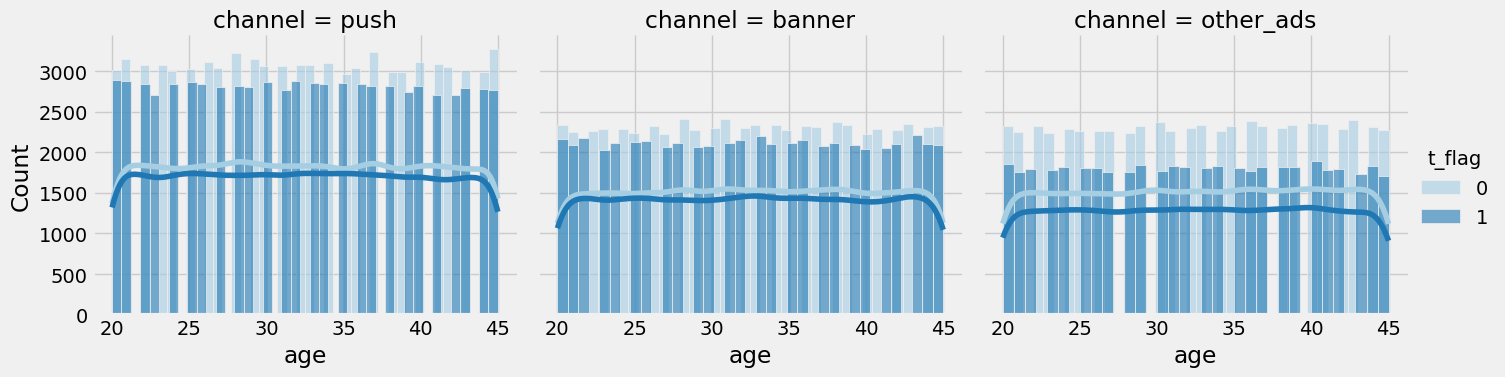

In [274]:
features_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9','age']
for col in features_cols:
    g = sns.FacetGrid(clear_set, col="channel", hue="t_flag", height=4, aspect=1.2, sharex=True, sharey=True)
    g.map(sns.histplot, col, alpha=0.6, kde=True)
    g.add_legend()
    plt.show()

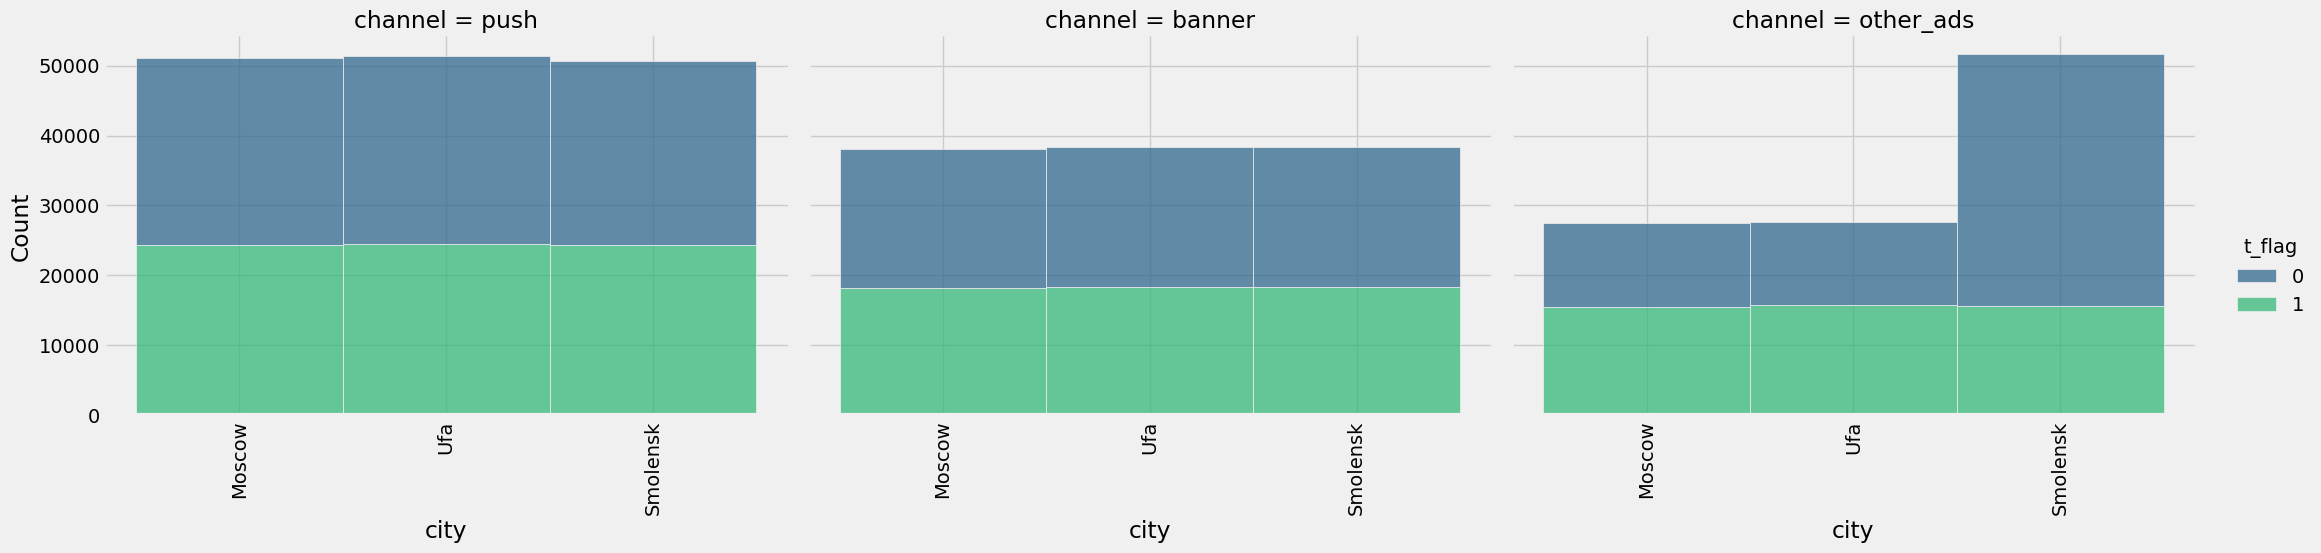

In [275]:
g = sns.displot(
        data=clear_set, x="city", 
        hue="t_flag",
        col="channel",
        multiple="stack", 
        height=5,
        aspect=1.5,
        palette="viridis"
)

# Поворачиваем подписи оси X для читаемости
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

plt.show()

##### X5 для канала other_ads полностью различаются, вероятно для контрольной группы в исходном наборе данных этот столбец просто пустой. Так же есть существенный перекос в пропорциях городов пользователей в той же кампании.

##### Посмотрим стат. значимость различий остальных признаков среди групп и каналов 
#### у меня слишком много времени заняла попытка установить библиотеку psi, поэтому я просто возьму функцию calculate_psi отсюда https://github.com/mwburke/population-stability-index/blob/master/psi.py

In [276]:
import numpy as np
from scipy.stats import ks_2samp

def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [278]:
clear_set

,channel,user_id,t_flag,delivery_date,contract_date,deadline,target,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,age,city
0,push,1162,1,2024-11-08,2024-11-13,2024-11-22,1,1161,-1.224545,1.688111,0.150933,3.230149,-0.189105,0.551481,-1.229590,1.159411,-0.085720,2024-09-30,39,Moscow
1,push,42991,1,2024-11-07,NaT,2024-11-21,0,42990,-0.916137,1.368764,1.841319,-1.529691,-0.608003,-1.116932,1.178124,-0.884607,-1.726070,2024-09-30,43,Moscow
2,push,24623,0,None,NaT,NaT,0,24622,2.281651,-0.354332,1.288191,-2.754188,0.202581,0.831745,-0.002779,-1.463527,1.976755,2024-09-30,39,Ufa
3,push,116064,0,None,2024-11-08,2024-11-21,1,116063,-0.773911,1.877601,0.582218,1.699295,-0.667554,-0.018505,0.337289,-1.101638,-0.936927,2024-09-30,33,Ufa
4,push,139714,0,None,NaT,NaT,0,139713,0.457746,1.407223,0.803963,-2.002316,0.928291,-1.389908,-1.823737,-0.512010,1.840791,2024-09-30,27,Ufa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374892,other_ads,2103141,1,2024-11-06,2024-11-12,2024-11-20,1,103141,0.189217,1.496285,-0.533316,-0.031895,2.101699,0.449041,1.473282,1.239368,-0.531401,2024-09-30,28,Ufa
374893,other_ads,2113479,0,None,NaT,NaT,0,113479,0.192611,-2.539540,-0.278562,-0.491431,0.000000,-0.161891,1.028837,1.110961,-0.403948,2024-09-30,21,Smolensk
374894,other_ads,2052080,1,2024-11-07,2024-11-25,2024-11-21,0,52080,-3.110953,-2.103578,1.327757,2.637593,0.374258,-0.133801,1.238193,0.767082,-1.068198,2024-09-30,36,Ufa
374895,other_ads,2046148,1,2024-11-06,2024-11-12,2024-11-20,1,46148,1.284552,-0.501500,-1.335027,0.754281,-1.614827,-0.975406,1.936397,1.443528,-0.476519,2024-09-30,43,Ufa


In [281]:
results = []
for col in features_cols:
    for channel in clear_set.channel.unique():
        expected = clear_set[clear_set.t_flag == 1][clear_set.channel == channel][col]
        actual = clear_set[clear_set.t_flag == 0][clear_set.channel == channel][col]
        assert len(expected) != 0 and len(actual) != 0, ''


        psi_value = calculate_psi(expected, actual, buckets=25) # записей вроде как достаточно, можем выставить побольше бинов  
        ks_stat, p_value = ks_2samp(expected, actual)

        results.append({'channel':channel,'Feature': col, 'PSI': psi_value, 'p-value': p_value})


psi_results_df = pd.DataFrame(results)


psi_results_df.sort_values('PSI')

,channel,Feature,PSI,p-value
16,banner,x6,0.000448,9.650071e-01
15,push,x6,0.000449,9.057811e-01
6,push,x3,0.000471,2.571071e-01
17,other_ads,x6,0.000500,8.041931e-01
28,banner,age,0.000568,5.887667e-01
4,banner,x2,0.000618,4.546041e-01
29,other_ads,age,0.000690,4.746497e-01
13,banner,x5,0.000791,3.557462e-01
3,push,x2,0.000804,2.038021e-01
27,push,age,0.000861,1.780001e-01


#### Вывод: Мы точно удаляем записи, в которых дата отправки больше, чем дата контракта. И мы также удаляем записи для каналов Other Ads, где delivery date это 8 ноября. На счет столбца X5 пока невозможно однозначно сказать, что лучше удалить сам признак из всех выборок, или проще избавиться от выборки с каналом Other Ads. Проверим вес этого признака после обучения моделей на других выборках и примем решение. Важность признака "city" тоже проверим при обучении моделей. А остальные признаки распределены практически идентично, их уже можно не трогать.



<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [291]:
# в начале обучи модели только на одном признаке и посмотрим какой uplift он позволит нам извлечь
# проверим таким образом ценность признаков а заодно и узнаем что там с х5

all_features = [*features_cols,'city']
result_list = []

for channel in clear_set.channel.unique():
    for feature_to_estimate in [*all_features,]: 

        X = clear_set.loc[clear_set.channel==channel][[feature_to_estimate,]]
        y = clear_set.loc[clear_set.channel==channel]['target']
        treatment = clear_set.loc[clear_set.channel==channel]['t_flag']
        
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)

        X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
            X, y, treatment, test_size=0.2, random_state=42
        )

        base_t_model = BaseTClassifier(
            LogisticRegression(random_state=42),
            control_name=0
        )
        base_t_model.fit(X_train, treatment=treat_train, y=y_train)
        uplift_pred_base = base_t_model.predict(X_test)[:,0]


        auc_score_result = qini_auc_score(y_true=y_test,
                          uplift=uplift_pred_base,
                          treatment=treat_test)

        result_list.append([channel,feature_to_estimate,auc_score_result])
result_frame = pd.DataFrame(result_list,columns=['channel','feature_to_estimate','auc_score_result'])

result_frame = result_frame.sort_values(['channel','auc_score_result'],ascending=False)
result_frame

,channel,feature_to_estimate,auc_score_result
6,push,x7,0.296695
8,push,x9,0.284338
7,push,x8,0.282502
0,push,x1,0.076500
4,push,x5,0.073151
3,push,x4,0.057122
9,push,age,0.005433
2,push,x3,0.004264
1,push,x2,0.000438
5,push,x6,-0.002889


##### В случае с banner и push ключевыми фичами являются x7,x8,x9 а x5 потчи не влияет на качество, в то время как для other_ads она становится главным признаком.
#### Если мы оставим её то не получим ничего для других кампаний, а для other_ads получим то, что наборы данных будут иметь разную структуру, в тесте буквально будет на 1 признак больше. Никакой пользы от неё в итоге не будет, можем удалить эту фичу.

#### Ранее, на графиках с распределением признаков, было видно, что не все распределения группируются вокруг какого-то одного числа. Например, признак X7 и X8 имеют два пика в распределении. Возможно это признаки, собранные из нескольких слагаемых, поэтому попробуем применить бинаризацию всех признаков, может быть, увидим какой-то прирост по качеству.

#### Можем перейти к пунктам из задания. Реализован только подход Solomodel без дополнительных библиотек и калибровок:

push


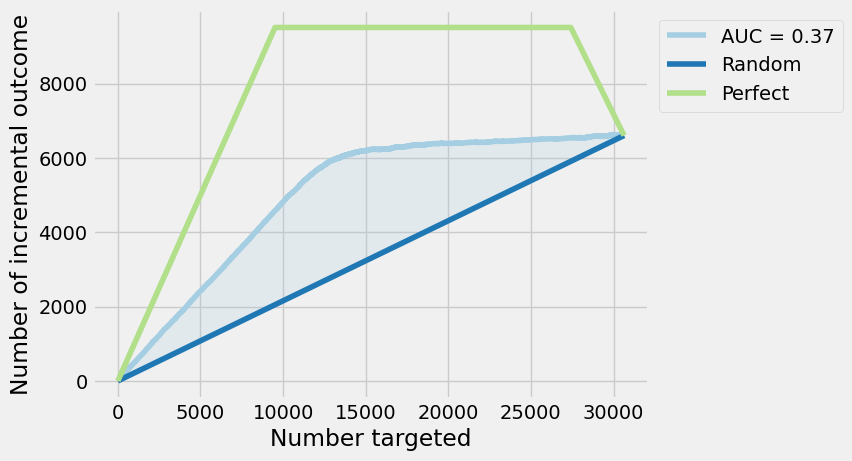

banner


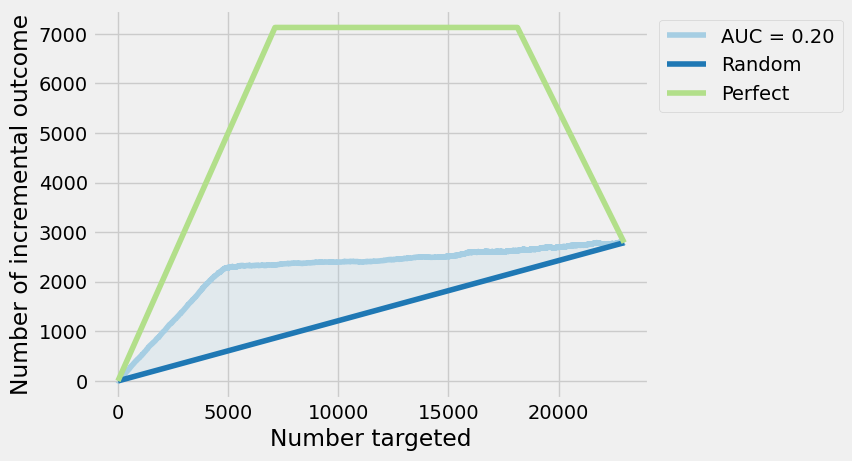

other_ads


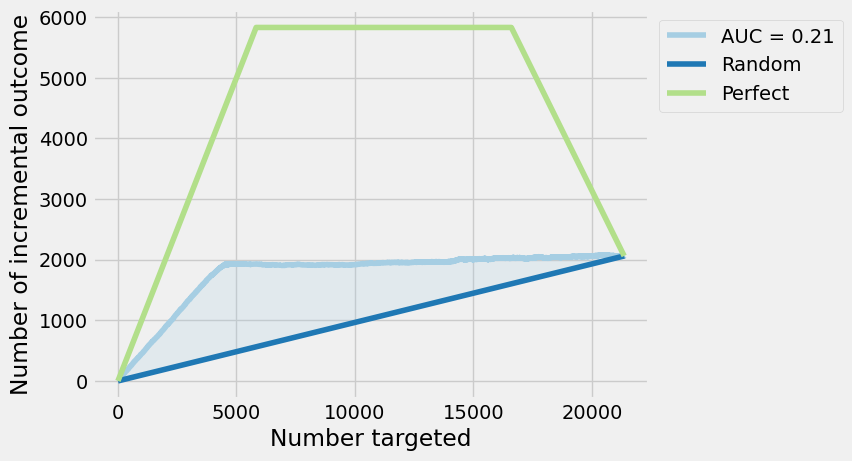

,channel,auc_qini
0,push,0.371403
2,other_ads,0.206347
1,banner,0.201135


In [335]:
all_features = ['x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x8', 'x9', 'age', 'city']

result_list = []

for channel in clear_set.channel.unique():
    print(channel)
    # Отбираем нужные данные
    X = clear_set.loc[clear_set.channel == channel][all_features]
    y = clear_set.loc[clear_set.channel == channel]['target']
    treatment = clear_set.loc[clear_set.channel == channel]['t_flag']

    # теперь разобьем признаки на бины, возможно это даст прирост в точности для линейной модели
    # проверка показала что прирост около 0.01 AUC, ну пусть будет =)     
    for feature_to_estimate in all_features:
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)
        
        else:
            min_val = X[feature_to_estimate].min()
            max_val = X[feature_to_estimate].max()
            
            bins = np.linspace(min_val, max_val, 21)  # 21 точка -> 20 интервалов

            X_binned = pd.cut(X[feature_to_estimate], bins=bins, right=False)
            X_binned = pd.get_dummies(X_binned, prefix=feature_to_estimate)
            X = pd.concat([X.drop(feature_to_estimate,axis=1),X_binned],axis=1)
        

        
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )

    X_train_control = X_train[treat_train == 0]
    y_train_control = y_train[treat_train == 0]
    
    X_train_treatment = X_train[treat_train == 1]
    y_train_treatment = y_train[treat_train == 1]

    model_control = LogisticRegression(random_state=42, solver='liblinear')
    model_control.fit(X_train_control, y_train_control)

    model_treatment = LogisticRegression(random_state=42, solver='liblinear')
    model_treatment.fit(X_train_treatment, y_train_treatment)
    
    
    # предсказываем вероятности для тестовой выборки для каждой модели
    pred_control = model_control.predict_proba(X_test)[:, 1]
    pred_treatment = model_treatment.predict_proba(X_test)[:, 1]

    # рассчитаем uplift на разности предсказанных вероятностей
    uplift = pred_treatment - pred_control

    auc_qini = qini_auc_score(
        y_true=y_test.values,
        uplift=uplift,
        treatment=treat_test.values
    )

    result_list.append([channel,auc_qini])


    plot_qini_curve(y_true=y_test.values,
                      uplift=uplift,
                      treatment=treat_test.values)
    plt.show()
        
result_frame = pd.DataFrame(result_list,columns=['channel','auc_qini'])
result_frame = result_frame.sort_values(['auc_qini'],ascending=False)
result_frame

#### Теперь можно перейти следующим пунктам:

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

In [471]:
result_list = []
models = {'push':None,
          'other_ads':None,
          'banner':None}

for channel in clear_set.channel.unique():
    X = clear_set.loc[clear_set.channel == channel][all_features]
    y = clear_set.loc[clear_set.channel == channel]['target']
    treatment = clear_set.loc[clear_set.channel == channel]['t_flag']
 
    for feature_to_estimate in all_features:
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)

#   разница не существенная, а данные потом еще потребуется преобразовывать чтобы сделать предикт на новых записях, поэтому отключим
#         else:
#             min_val = X[feature_to_estimate].min()
#             max_val = X[feature_to_estimate].max()
            
#             bins = np.linspace(min_val, max_val, 21)  # 21 точка -> 20 интервалов

#             X_binned = pd.cut(X[feature_to_estimate], bins=bins, right=False)
#             X_binned = pd.get_dummies(X_binned, prefix=feature_to_estimate)
#             X = pd.concat([X.drop(feature_to_estimate,axis=1),X_binned],axis=1)
        

        
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )
    
    # калибруем вероятности и используем металернер
    calibrated_lr = CalibratedClassifierCV(LogisticRegression(random_state=42), cv=3)
    base_t_model_calibrated = BaseTClassifier(
        calibrated_lr,
        control_name=0
    )
    base_t_model_calibrated.fit(X_train, treatment=treat_train, y=y_train)
    uplift_pred_base = base_t_model_calibrated.predict(X_test)[:, 0]

    auc_score_result = qini_auc_score(y_true=y_test,
                                      uplift=uplift_pred_base,
                                      treatment=treat_test)

    result_list.append([channel, feature_to_estimate, auc_score_result])
    models[channel] = base_t_model_calibrated
    
result_frame = pd.DataFrame(result_list, 
                            columns=['channel', 'feature_to_estimate', 'auc_score_result'])
result_frame = result_frame.sort_values(['channel','auc_score_result'], ascending=False)
result_frame

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without

,channel,feature_to_estimate,auc_score_result
0,push,city,0.36357707
2,other_ads,city,0.21035907
1,banner,city,0.19947614


#### Далее выполняем реализацию для 

* Корректно реализован ClassTransformation - **2 балла**


In [486]:


result_list = []

for channel in clear_set.channel.unique():
    X = clear_set.loc[clear_set.channel == channel][all_features]
    y = clear_set.loc[clear_set.channel == channel]['target']
    treatment = clear_set.loc[clear_set.channel == channel]['t_flag']
    
    for feature_to_estimate in all_features:
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)
        else:
            min_val = X[feature_to_estimate].min()
            max_val = X[feature_to_estimate].max()
            bins = np.linspace(min_val, max_val, 21)
            X_binned = pd.cut(X[feature_to_estimate], bins=bins, right=False)
            X_binned = pd.get_dummies(X_binned, prefix=feature_to_estimate)
            X = pd.concat([X.drop(feature_to_estimate, axis=1), X_binned], axis=1)
    
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )
    
    calibrated_lr = CalibratedClassifierCV(LogisticRegression(random_state=42), cv=3)
    ct_model = ClassTransformation(calibrated_lr)
    ct_model.fit(X_train, treatment=treat_train, y=y_train)
    uplift_pred_ct = ct_model.predict(X_test)
    
    auc_score_result = qini_auc_score(
        y_true=y_test,
        uplift=uplift_pred_ct,
        treatment=treat_test
    )
    
    result_list.append([channel, feature_to_estimate, auc_score_result])

result_frame = pd.DataFrame(result_list, columns=['channel', 'feature_to_estimate', 'auc_score_result'])
result_frame = result_frame.sort_values(['channel', 'auc_score_result'], ascending=False)
result_frame

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

,channel,feature_to_estimate,auc_score_result
0,push,city,0.36197081
2,other_ads,city,0.20584741
1,banner,city,0.20097549


#### Далее выполняем реализацию для 

* Реализован UpliftRandomForest - **4 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [414]:
result_list = []

for channel in clear_set.channel.unique():
    X = clear_set.loc[clear_set.channel == channel][all_features].copy()
    y = clear_set.loc[clear_set.channel == channel]['target']
    treatment = clear_set.loc[clear_set.channel == channel]['t_flag'].astype(str)
    
    for feature_to_estimate in all_features:
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    treatment = treatment.reset_index(drop=True)
    
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )
    
    # приводим имена столбцов к строковому типу
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    
    uplift_rf = UpliftRandomForestClassifier(
        n_estimators=100,
        control_name='0',
        random_state=42,
        max_depth=5,
        min_samples_leaf=150
    )
    uplift_rf.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
    uplift_pred_rf = uplift_rf.predict(X_test.values)[:, 0]
    

    auc_score_result = qini_auc_score(
        y_true=y_test.values,
        uplift=uplift_pred_rf.round(),
        treatment=treat_test.astype(int)
    )
    
    result_list.append([channel, feature_to_estimate, auc_score_result])
    
result_frame = pd.DataFrame(result_list, columns=['channel', 'feature_to_estimate', 'auc_score_result'])
result_frame = result_frame.sort_values(['channel', 'auc_score_result'], ascending=False)
result_frame


,channel,feature_to_estimate,auc_score_result
0,push,city,0.319033
2,other_ads,city,0.171739
1,banner,city,0.155703


In [420]:
result_list = []

for channel in clear_set.channel.unique():
    print(channel)
    X = clear_set.loc[clear_set.channel == channel][all_features].copy()
    y = clear_set.loc[clear_set.channel == channel]['target']
    treatment = clear_set.loc[clear_set.channel == channel]['t_flag'].astype(str)
    
    for feature_to_estimate in all_features:
        if feature_to_estimate == 'city':
            X = pd.get_dummies(X, columns=['city'], drop_first=True)
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    treatment = treatment.reset_index(drop=True)
    
    X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
        X, y, treatment, test_size=0.2, random_state=42
    )
    
    X_train.columns = X_train.columns.astype(str)
    X_test.columns = X_test.columns.astype(str)
    
    
    best_score = -np.inf
    best_params = {}
    for n_estimators in [10, 20, 100]:
        for max_depth in [3, 5, 7]:
            for min_samples_leaf in [50, 100]:
                model = UpliftRandomForestClassifier(
                    n_estimators=n_estimators,
                    control_name='0',
                    random_state=42,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf
                )
                model.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
                uplift_pred = model.predict(X_test.values)[:, 0]
                score = qini_auc_score(
                    y_true=y_test.values,
                    uplift=uplift_pred,
                    treatment=treat_test.values.astype(int)
                )
                if score > best_score:
                    best_score = score
                    best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}
    
    result_list.append([channel, feature_to_estimate, score])
    
result_frame = pd.DataFrame(result_list, columns=['channel', 'feature_to_estimate', 'auc_score_result'])
result_frame = result_frame.sort_values(['channel', 'auc_score_result'], ascending=False)
print(best_params)
result_frame

push
banner
other_ads
{'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 100}


,channel,feature_to_estimate,auc_score_result
0,push,city,0.364643
2,other_ads,city,0.200350
1,banner,city,0.194771


<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

In [488]:
features.loc[features.report_dt==features.report_dt.max()]

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,report_dt,user_id,age,city
2,227077,0.29603049,-0.93707495,1.07328024,1.87463572,-0.98121568,-1.10018697,-0.33118103,-1.57563692,0.47496544,2025-03-31,4063636,28,Ufa
3,304649,2.32932815,-1.34515910,0.34506562,0.75537306,-0.08284231,0.02843869,0.91921109,0.80879331,-0.56000383,2025-03-31,1025488,27,Moscow
5,113456,1.48421157,-1.74058117,3.66761061,-0.21071807,-1.05269852,1.19157463,-2.01356860,-3.35944873,1.56019931,2025-03-31,36478,42,Moscow
8,274767,-2.33073391,0.39986419,-0.10185489,2.80077421,-1.63255040,1.00609833,0.43857070,0.33079298,0.16326949,2025-03-31,4032069,22,Smolensk
9,5679,1.80656735,-1.35696185,2.72199202,-1.82795393,0.16616179,0.84175822,1.29502211,-0.14282120,-0.86539241,2025-03-31,104929,35,Moscow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759974,94165,0.67202850,-0.50373459,0.80778591,1.80531692,-0.14457120,0.21028889,-1.12929147,-0.84317665,0.75455560,2025-03-31,4019653,28,Ufa
2759985,318712,-0.97105536,-0.12923815,0.15881712,0.97041113,1.14202348,-0.65868609,0.74981705,1.45949091,-0.78365505,2025-03-31,4069460,24,Ufa
2759987,46644,3.44262771,-1.93101068,2.23380704,0.49162844,2.07434341,0.41108156,-0.70702695,-0.71202421,-0.11256072,2025-03-31,154640,23,Smolensk
2759989,65061,-0.62614010,-0.27831735,-0.75578236,2.37460838,-0.06351921,-0.56030388,-1.23532168,-1.77336001,0.79983234,2025-03-31,2004906,39,Ufa


In [496]:
# достаем сохранённые откалиброванные модели, применяем каждому клиенту и сохраняем это в один большой датафрейм
# полагаю на не требуется скорить клиентов задним числом, поэтому оставляем только самый последний срез аггрегатов

result = []
for channel, model in models.items():
    temp_features = pd.get_dummies(features.loc[features.report_dt==features.report_dt.max()][all_features], columns=['city'], drop_first=True)
    uplift_result = model.predict(temp_features)[:, 0]
    frame = pd.concat([features[['user_id','report_dt']],pd.Series([channel]*len(uplift_result)),pd.Series(uplift_result)],axis=1)
    result.append(frame)
result = pd.concat(result)
result.columns = ['user_id','report_dt','channel','uplift']
result

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without

,user_id,report_dt,channel,uplift
0,1066338,2025-01-31,push,0.14712595
1,13900,2024-11-30,push,0.96566634
2,4063636,2025-03-31,push,-0.01466378
3,1025488,2025-03-31,push,0.00322087
4,4040555,2025-02-28,push,0.17428638
...,...,...,...,...
2759995,61957,2025-02-28,NaN,NaN
2759996,132172,2025-01-31,NaN,NaN
2759997,4028256,2025-03-31,NaN,NaN
2759998,1097844,2025-02-28,NaN,NaN


In [490]:
pd.set_option('display.float_format', '{:.8f}'.format)

In [491]:
result.groupby('channel').agg({'uplift':'sum'})

,uplift
channel,
banner,58738.76711362
other_ads,56438.17239676
push,203377.00675932


<Axes: >

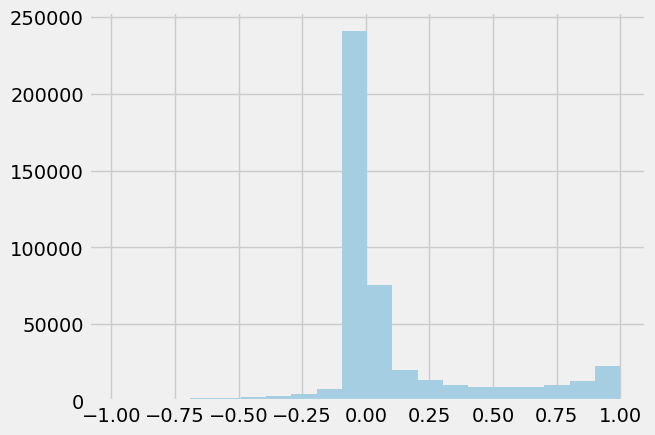

In [492]:
result.loc[result.channel=='banner'].uplift.hist(bins=20)

<Axes: >

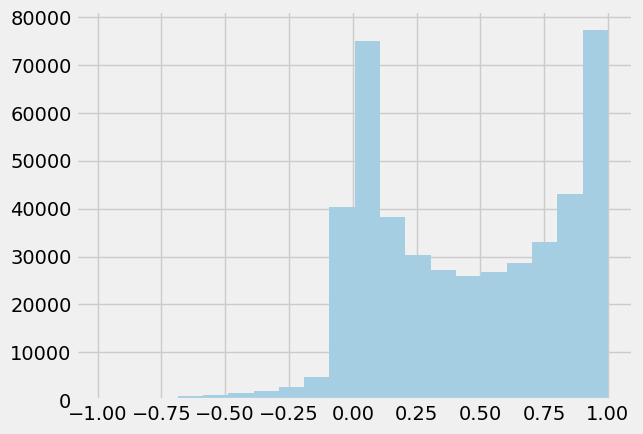

In [493]:
result.loc[result.channel=='push'].uplift.hist(bins=20)

<Axes: >

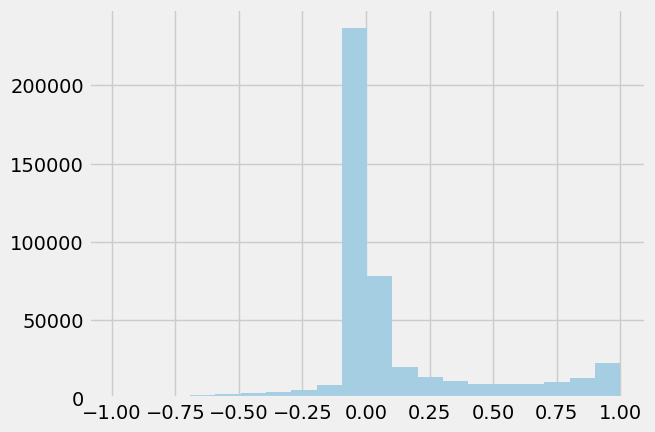

In [494]:
result.loc[result.channel=='other_ads'].uplift.hist(bins=20)

In [495]:
result.to_csv('result.csv')

### ваши выводы здесь


В данной работе был проведен анализ представленных данных. Была определена кампания, данные для которой были собраны некорректно. Были определены выбросы, связанные с некорректной датой совершения операции. Также были удалены дни, в которых слишком высокий результат(100%) у кампании. 

Были построены несколько моделей для оценки uplift, включая Twomodel с логистической регрессией, UpliftRandomForestClassifier и ClassTransformation. В конечном итоге, для прогноза использовались модели логистической регрессии с откалиброванными вероятностями, обёрнутые в Twomodel, поскольку альтернативные подходы не обеспечили значительного улучшения метрик.

Наиболее эффективным каналом можно уверенно считать push, его uplift_effieciency на исходных данных уже составляло 0.45, а при обучении моделей удалось достичь qini_auc_score = 0.37 на тесте.


* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

Решение об отправке коммуникации клиентам должно приниматься с учётом затрат на рассылку: если математическое ожидание отклика (доход с операции умноженный на uplift вероятно) превышает стоимость коммуникации, имеет смысл проводить рассылку. А этих данных у нас не было в исходном наборе, можем считать что есть некий порог, выше которого есть смысл отправлять коммуникацию, тогда просто обрежем датасет по этому порогу.